# Bidirectional RNN

In this notebook, we trained a bidirectional LSTM for the two classification tasks.

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

from tensorflow import keras
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, Conv1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, BatchNormalization, Bidirectional, LSTM, Flatten, GaussianNoise, Add
from keras.models import load_model, Model, Sequential

from livelossplot import PlotLossesKeras 

import tsfel
from tsfel.feature_extraction.calc_features import calc_window_features

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from itertools import product

# custom modules
from utils import *
from cf_matrix import *
from model_parts import *
from data import get_tsfel_features

In [2]:
# !pip install livelossplot
# !pip install tsfel

In [2]:
%load_ext autoreload
%autoreload 2

## Set default parameters

In [3]:
# Training parameters
EPOCHS = 40
BATCH_SIZE = 32

# Hyperparameters
N_FILT = 32
KERNEL_SIZE = 11
SEQUENCE_LENGTH = 187
NO_CLASSES = 5
N_CHANNELS = 1

## MITBIH Model

### Load data

In [40]:
df_train = pd.read_csv("./data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1, random_state=42)
df_test = pd.read_csv("./data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Define Bi-LSTM model

In [42]:
model = Sequential([ Bidirectional(LSTM(SEQUENCE_LENGTH), input_shape=(SEQUENCE_LENGTH,1)),
                     Dense(64, activation='relu'),
                     Dense(NO_CLASSES, activation='softmax')
                   ])

In [43]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

### Train model

In [ ]:
file_path = './models/bilstm_mitbih.h5'
history = run_add_cnn_experiment(model, [X,Y], [X_test, Y_test], skip_feats = None,
                           weight_file_path=file_path, 
                           batch_size = BATCH_SIZE, num_epochs = EPOCHS)

### Evaluate model

f1 score micro:           0.98671
f1 score macro:           0.92391
accuracy score:           0.98671
balanced accuracy score:  0.90244


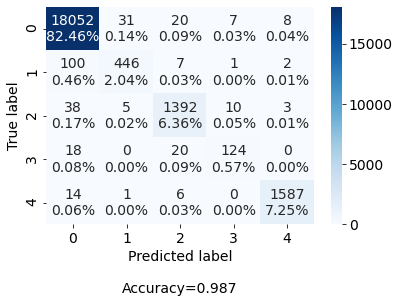

In [44]:
file_path = './models/bilstm_mitbih.h5'
model.load_weights(file_path) 

pred_test_proba = model.predict(X_test)
pred_test = np.argmax(pred_test_proba, axis=-1)

display_result(Y_test, pred_test)

### Store predictions

In [40]:
np.save("./predictions/test_mitbih_bilstm", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_bilstm", pred_test_proba, allow_pickle=True)

In [41]:
pred_train_proba = model.predict(X)
pred_train = np.argmax(pred_train_proba, axis=-1)

np.save("./predictions/train_mitbih_proba_bilstm", pred_train_proba, allow_pickle=True)
np.save("./predictions/train_mitbih_bilstm", pred_train, allow_pickle=True)

# PTBDB Model

## Load data

In [4]:
df_1_ptb = pd.read_csv("./data/ptbdb_normal.csv", header=None)
df_2_ptb = pd.read_csv("./data/ptbdb_abnormal.csv", header=None)
df_ptb = pd.concat([df_1_ptb, df_2_ptb])

df_train_ptb, df_test_ptb = train_test_split(df_ptb, test_size=0.2, random_state=1337, stratify=df_ptb[187])


Y_ptb = np.array(df_train_ptb[187].values).astype(np.int8)
X_ptb = np.array(df_train_ptb[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test_ptb[187].values).astype(np.int8)
X_test_ptb = np.array(df_test_ptb[list(range(187))].values)[..., np.newaxis]

## Training

In [29]:
EPOCHS = 100 # Due to faster training time, we increase number of epochs

In [38]:
TRANSFER = True # configure to use transfer learning or not 

When transfer learning we initialize the weights with the pretrained ones from the MITBIH dataset, train the complete network on the new data and use learning rate scheduling, early stopping to prevent overfitting

In [39]:
# we will later change to a binary classification head instead of 5 classes
model_ptb_raw = Sequential([ Bidirectional(LSTM(SEQUENCE_LENGTH), input_shape=(SEQUENCE_LENGTH,1)),
                     Dense(64, activation='relu'),
                     Dense(5, activation='softmax')
                   ])

In [40]:
opt_ptb = optimizers.Adam(0.001)
model_ptb_raw.compile(optimizer=opt_ptb, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])

In [41]:
# Load weights from MITBIH for transfer learning (comment out if training purely)
if TRANSFER:
    print("Loading pretrained weights from MITBIH dataset")
    weight_file_path ='./models/bilstm_mitbih.h5'
    model_ptb_raw.load_weights(weight_file_path)
    
transfer_str = "_transfer" if TRANSFER else "" 

Loading pretrained weights from MITBIH dataset


### Reconfigure model

Reconfigure the model to have binary classification head instead of 5 classes

In [42]:
new_out = Dense(1, activation=activations.sigmoid, name="ptb_sigmoid")(model_ptb_raw.layers[-2].output)

model_ptb = Model(inputs=model_ptb_raw.input, outputs=new_out)
model_ptb.compile(optimizer=opt_ptb, loss=losses.BinaryCrossentropy(), metrics=['acc'])

### Fitting

In [43]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 

weight_file_path_ptb = f"./models/bilstm_ptb{transfer_str}.h5"
checkpoint = ModelCheckpoint(weight_file_path_ptb, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat]

In [ ]:
 model_ptb.fit(
    X_ptb, Y_ptb, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, 
    callbacks=callbacks_list,  
    validation_split=0.1,
    shuffle=True,
)

### Evaluation

f1 score micro:           0.99553
f1 score macro:           0.99443
accuracy score:           0.99553
balanced accuracy score:  0.99387
AuPR score:               0.99955
AuROC score:              0.99895


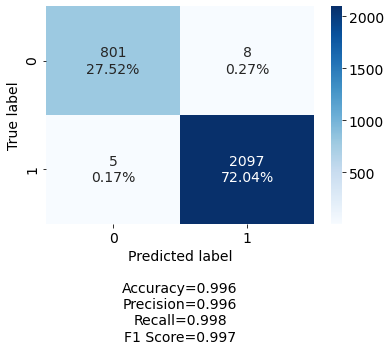

In [44]:
# load best weights
model_ptb.load_weights(weight_file_path_ptb) 

pred_test_proba = model_ptb.predict(X_test_ptb)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]

display_result(Y_test_ptb, pred_test, curve=True, proba=pred_test_proba)

### Store predictions

In [27]:
np.save(f"./predictions/test_ptb_bilstm{transfer_str}", pred_test, allow_pickle=True)
np.save(f"./predictions/test_ptb_proba_bilstm{transfer_str}", pred_test_proba, allow_pickle=True)

In [28]:
pred_train_proba = model_ptb.predict(X_ptb)
pred_train = [1 if x > 0.5 else 0 for x in pred_train_proba]
np.save(f"./predictions/train_ptb_bilstm{transfer_str}", pred_train, allow_pickle=True)
np.save(f"./predictions/train_ptb_proba_bilstm{transfer_str}", pred_train_proba, allow_pickle=True)